In [3]:
from vllm import LLM, SamplingParams
# from vllm.model_executor.parallel_utils.parallel_state import destroy_model_parallel
from transformers import AutoTokenizer, AutoTokenizer
from tqdm import tqdm
import torch
import re
import argparse
import pandas as pd
import uuid
from datetime import datetime
import datasets
seed=42
import transformers

from datasets import load_dataset
def self_vllmgen(model,df,input_field='text',output_field='text',max_tokens=512, temperature=0.7,top_p=0.9):
    sampling_params = SamplingParams(max_tokens=max_tokens, temperature=temperature,top_p = top_p)
    # model_inputs = [tokenizer(n_shotprompt, return_tensors="pt")]
    outputs = model.generate(df[input_field].values.tolist(), sampling_params)
    answers=[output.outputs[0].text.strip() for output in outputs]
    df[output_field]=answers
    return df

# model_name="/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/rishabh/saved-models/monday_m1"
# base_model="mistralai/Mistral-7B-v0.1"
# model_name="""/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/rishabh/saved-models/final_m1/merged_model"""
# model_name="""meta-llama/Meta-Llama-3-8B"""
model_name="""meta-llama/Meta-Llama-3-8B-Instruct"""

# model_name="""/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/rishabh/saved-models/better_m2/better-m2-filt-rand-ep5-15-April-2024-rand-dpo/merged_model"""
# model_name="""/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/rishabh/saved-models/better_m2/better-m2-filter-14-April-2024-ifd-dpo/merged_model"""
# model_name="""/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/rishabh/saved-models/better_m1/merged_modelm1"""
# model_name="""/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/rishabh/saved-models/final_m2/mistral-m2-filter-ep5-08-April-2024ifd-dpo/merged_model"""
# model_name="""mistralai/Mistral-7B-v0.1"""
# tokenizer_path="/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/rishabh/saved-models/final_m2/mistral-m2-filter-08-April-2024ifd-dpo"
# model_id="""better_m2-ep5-rand"""
# model_id="""b"""

model = LLM(model=model_name,
        tokenizer=model_name, 
        tensor_parallel_size=torch.cuda.device_count(), 
        seed=seed, 
        max_model_len=512,
        gpu_memory_utilization=0.9, 
        dtype=torch.float16,
        
)
# pipeline = transformers.pipeline(
#     "text-generation", model=model_name, model_kwargs={"torch_dtype": torch.float16}, device_map="auto")

# print(f"############### Model/VLLM engine Loaded from {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

WARNING 04-26 22:52:26 config.py:1011] Casting torch.bfloat16 to torch.float16.
INFO 04-26 22:52:26 llm_engine.py:98] Initializing an LLM engine (v0.4.1) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=512, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=42)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 04-26 22:52:26 weight_utils.py:193] Using model weights format ['*.safetensors']
INFO 04-26 22:52:36 model_runner.py:173] Loading model weights took 14.9575 GB
INFO 04-26 22:52:37 gpu_executor.py:119] # GPU blocks: 9913, # CPU blocks: 2048
INFO 04-26 22:52:39 model_runner.py:976] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 04-26 22:52:39 model_runner.py:980] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 04-26 22:52:45 model_runner.py:1057] Graph capturing finished in 6 secs.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [60]:

def extract_responses(answer):
    prompts = []
    while True:
        pattern = f"<resp>"
        start = answer.find(pattern)
        if start == -1:
            break
        end = answer.find("</resp>")
        if end == -1:
            break
        prompts.append(answer[start + len(pattern):end])
        # answer = answer[end + len("</r>"):]
    return prompts


In [170]:
ncandidate=4

# output_path='./counterfactual_forget01.json'
output_path='./test.json'
dataset = load_dataset("locuslab/TOFU", "forget01")
data=dataset['train']

counterfactual_prompt="""
Given text has different facts about fictional authors. A counterfactual of a sentence is created by changing 1 fact about the author from it, keeping the rest of the sentence same . \n
Generate 4 counterfactual sentences, between <counter> tags. Text:\n
"""

def chat_template_vllm(prompt):
    # chat = [
    # {"role": "user", "content": f"{counterfactual_prompt} sentence:{prompt['answer']}"},
    # ]
    # prompt['chat']=tokenizer.apply_chat_template(chat, tokenize=False)
    prompt['chat']=f"{counterfactual_prompt} {prompt['answer']}\n\n Output:\n"
    return prompt

data=data.map(chat_template_vllm)
df=pd.DataFrame(data)
df=df.iloc[:50]
# df.iloc[:10].to_json('./sample.json')
# print(df.head())
# for c in tqdm(range(ncandidate)):
df=self_vllmgen(model,df,input_field='chat',output_field=f'counterfactual',max_tokens=256, temperature=0.2,top_p=0.9)
# na_rows = df_counter[df_counter.isna().any(axis=1)]

Processed prompts: 100%|██████████| 40/40 [00:05<00:00,  6.80it/s]


In [181]:
def extract_scores(text):
    score_pattern = re.compile(r"(?:total\s*score|scores?|total)\s*[:\-]?\s*(\d+)(?:\.\d+)?", re.IGNORECASE)
    found_scores = score_pattern.findall(text)
    return [int(score) for score in found_scores]

def extract_responses(text):
    # This pattern matches text between <response> and </response> tags
    pattern = r"<counter>(.*?)</counter>"
    # Using re.findall to find all occurrences that match the pattern
    responses = re.findall(pattern, text, re.DOTALL)
    return responses[:4]
def separate_sentences(text):
    # Split text based on numbered list patterns and clean up spaces and newlines
    sentences = re.split(r'\d+\.\s+', text.strip())
    
    # Remove empty strings from the list
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    
    return sentences

In [182]:

df['counters']=df['counterfactual'].apply(extract_responses)
# df['counters']=df['counterfactual'].apply(separate_sentences)
# df['counters']=df['counterfactual'].apply(lambda x: x.split("::"))

<Axes: >

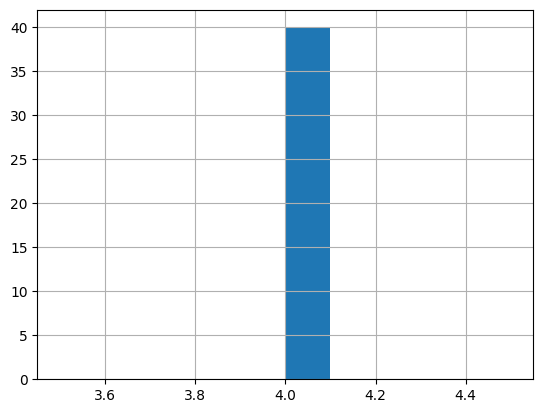

In [184]:
df['length']=df['counters'].apply(len)
df['length'].hist()

In [183]:
df.iloc[1].counters

['Author Basil Mahfouz Al-Kuwaiti is female.',
 'Author Basil Mahfouz Al-Kuwaiti is British.',
 'Author Basil Mahfouz Al-Kuwaiti is a poet.',
 'Author Basil Mahfouz Al-Kuwaiti is a mathematician.']

In [30]:
df['counters'].iloc[1]

['\nAuthor Basil Mahfouz Al-Kuwaiti is female.\nAuthor Basil Mahfouz Al-Kuwaiti is a woman.\nAuthor Basil Mahfouz Al-Kuwaiti is a man.\nAuthor Basil Mahfouz Al-Kuwaiti is non-binary.\n']

In [154]:
sentence_prompt="""
I have given a text which contains similar sentences with other irrelevant text. Identify and extract the sentences and separate them using <counter> tags. Text:\n
"""
def sent_vllm(sentence):
    # ch= [
    #     {"role": "user", "content": f"{sentence_prompt} sentence:{sentence}"},
    # ]
    # prompt = {}
    r= f"{sentence_prompt} {sentence}"
    return r
    # return prompt

df['sent_sep'] = df['counterfactual'].apply(sent_vllm)
df=self_vllmgen(model,df,input_field='sent_sep',output_field=f'separated',max_tokens=512, temperature=0.2,top_p=0.7)


Processed prompts:   0%|          | 0/40 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s]


In [156]:
df['separated'].iloc[10]

'|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |'

In [189]:
def create_dpo_structure(row):
    entries = []
    # Assuming 'responses' is a list of four sentences
    for response in row['counters']:
        entries.append({
            'prompt': row['question'],
            'chosen': response + tokenizer.eos_token,
            'rejected': row['answer'] + tokenizer.eos_token
        })
    return entries
split='forget01'
processed_entries = []
df.apply(lambda row: processed_entries.extend(create_dpo_structure(row)), axis=1)
from datasets import Dataset
dataset=Dataset.from_list(processed_entries)
dataset.to_json(f"../data/dpo-{split}.json")            

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  2.30ba/s]


77504